In [3]:
pip install pandas numpy scikit-learn xgboost shap matplotlib joblib imbalanced-learn

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB 1.4 MB/s eta 0:00:42
   ---------------------------------------- 0.1/56.8 MB 919.0 kB/s eta 0:01:02
   ---------------------------------------- 0.1/56.8 MB 939.4 kB/s eta 0:01:01
   ---------------------------------------- 0.1/56.8 MB 853.3 kB/s eta 0:01:07
   ---------------------------------------- 0.2/56.8 MB 1.2 MB/s eta 0:00:49
   ---------------------------------------- 0.2/56.8 MB 1.2 MB/s eta 0:00:49
   ---------------------------------------- 0.2/56.8 MB 1.2 MB/s eta 0:00:49
   ---------------------------------------- 0.2/56.8 MB 1.2 MB/s eta 0:00:49
   ---------------------------------------- 0.2/56.8 MB 1.2 MB/s eta 0:00:49
   ---------------------------------------- 0.4/56.8 MB 882.8 kB/s eta 0:01:04
   ---------------------------------------- 0.4/56.8 MB 860.2 kB/s eta 0:01:06
   ---------------------------------------- 0.5/56.8 MB 894.8 kB/s eta 0:

In [4]:
import os, json, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, average_precision_score, classification_report,
confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_class_weight
from joblib import dump

In [6]:


from xgboost import XGBClassifier
import shap

In [7]:
ID_COL = "customerID" # change if needed
TARGET = "Churn" # 1 = churn, 0 = not churn
CSV_PATH = "data/churn.csv" # change if needed
OUT_DIR = "outputs"
ART_DIR = "artifacts"
RANDOM_STATE = 42
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(ART_DIR, exist_ok=True)

In [17]:
# ---------- LOAD DATA ----------
df = pd.read_csv(CSV_PATH)
assert TARGET in df.columns, f"Target column '{TARGET}' not found."
if ID_COL not in df.columns:
    create a surrogate ID 
    if none exists
    df[ID_COL] = np.arange(len(df))

SyntaxError: invalid syntax (2422339207.py, line 5)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier

In [11]:
# =============================
# 2) LOAD DATA
# =============================
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

print("Shape:", df.shape)
print(df.head())

Shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies   

In [13]:
# =============================
# 3) CLEAN DATA
# =============================
# Convert TotalCharges to numeric (it has some blanks)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Encode target column
df["Churn"] = df["Churn"].map({"Yes":1, "No":0})

# Drop customerID (not useful)
df = df.drop(columns=["customerID"])

# Encode categorical features
for col in df.select_dtypes(include="object").columns:
    df[col] = LabelEncoder().fit_transform(df[col])

In [15]:
# =============================
# 4) TRAIN-TEST SPLIT
# =============================
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [17]:
# =============================
# 5) TRAIN MODEL (XGBoost)
# =============================
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
model.fit(X_train, y_train)

C:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:33:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.60      0.52      0.55       374

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409

ROC AUC: 0.8185396161099487


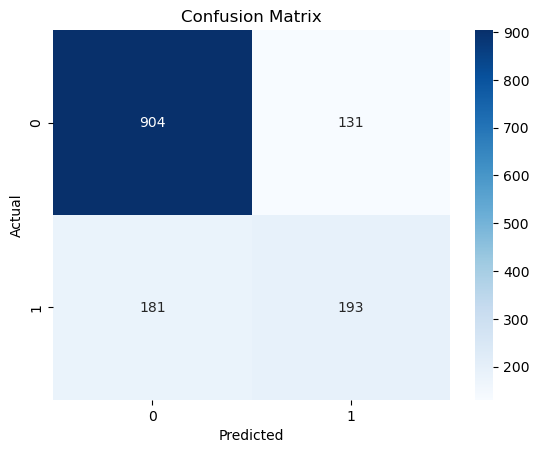

In [19]:

# =============================
# 6) PREDICTIONS & METRICS
# =============================
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


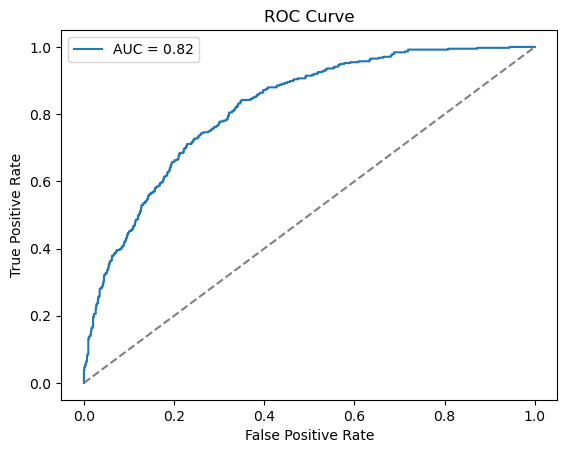

In [21]:

# =============================
# 7) ROC CURVE
# =============================
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

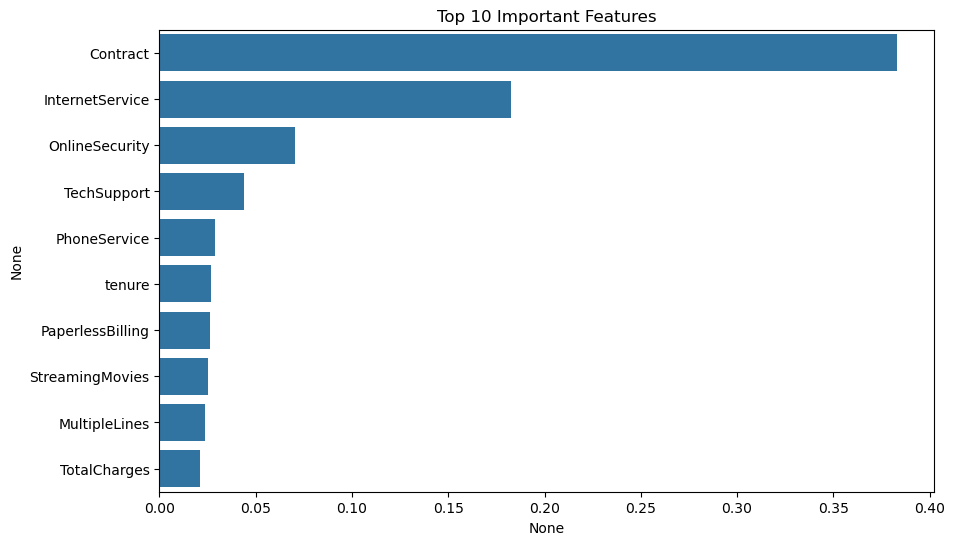

In [25]:





# =============================
# 8) FEATURE IMPORTANCE
# =============================
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Important Features")
plt.show()

In [27]:
import os

# Generate predictions again (already done above, but keeping it consistent)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Create results DataFrame
results = df.loc[X_test.index].copy()   # take test set rows
results["Actual_Churn"] = y_test.values
results["Predicted_Churn"] = y_pred
results["Churn_Probability"] = y_proba

# 🔹 Save CSV to Desktop
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "churn_results.csv")
results.to_csv(desktop_path, index=False)

print("✅ Churn results exported successfully!")
print(f"📂 File saved at: {desktop_path}")


✅ Churn results exported successfully!
📂 File saved at: C:\Users\User\Desktop\churn_results.csv
